<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Semantic Segmentation using IceVision

## Install

Install from pypi...

## Imports

In [1]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/dnth/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/dnth/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


## Getting and parsing the data

In [2]:
# data_url = 'https://s3.amazonaws.com/fast-ai-sample/camvid_tiny.tgz'
# data_dir = icedata.load_data(data_url, 'camvid_tiny') / 'camvid_tiny'

In [3]:
# codes = np.loadtxt(data_dir/'codes.txt', dtype=str)
# class_map = ClassMap(list(codes))

In [4]:
# list(codes)

In [5]:
# class_map

In [6]:
# images_dir = data_dir/'images'
# labels_dir = data_dir/'labels'
# image_files = get_image_files(images_dir)
# records = RecordCollection(SemanticSegmentationRecord)

# for image_file in pbar(image_files):
#     record = records.get_by_record_id(image_file.stem)

#     if record.is_new:
#         record.set_filepath(image_file)
#         record.set_img_size(get_img_size(image_file))
#         record.segmentation.set_class_map(class_map)

#     mask_file = SemanticMaskFile(labels_dir / f'{image_file.stem}_P.png')
#     record.segmentation.set_mask(mask_file)
    
# records = records.autofix()
# train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

In [7]:
data_dir = Path('./Segmantic-segmentation-crackRoad-main/dataset')

In [8]:
images_dir = data_dir/'img_png'
labels_dir = data_dir/'label_png'

In [9]:
image_files = get_image_files(images_dir)

In [10]:
class_map = ClassMap(["Crack", "Road"])

In [11]:
class_map

<ClassMap: {'background': 0, 'Crack': 1, 'Road': 2}>

In [12]:
records = RecordCollection(SemanticSegmentationRecord)

for image_file in pbar(image_files):
    record = records.get_by_record_id(image_file.stem)

    if record.is_new:
        record.set_filepath(image_file)
        record.set_img_size(get_img_size(image_file))
        record.segmentation.set_class_map(class_map)

    mask_file = SemanticMaskFile(labels_dir / f'{image_file.stem}.png')
    record.segmentation.set_mask(mask_file)
    
records = records.autofix()
train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

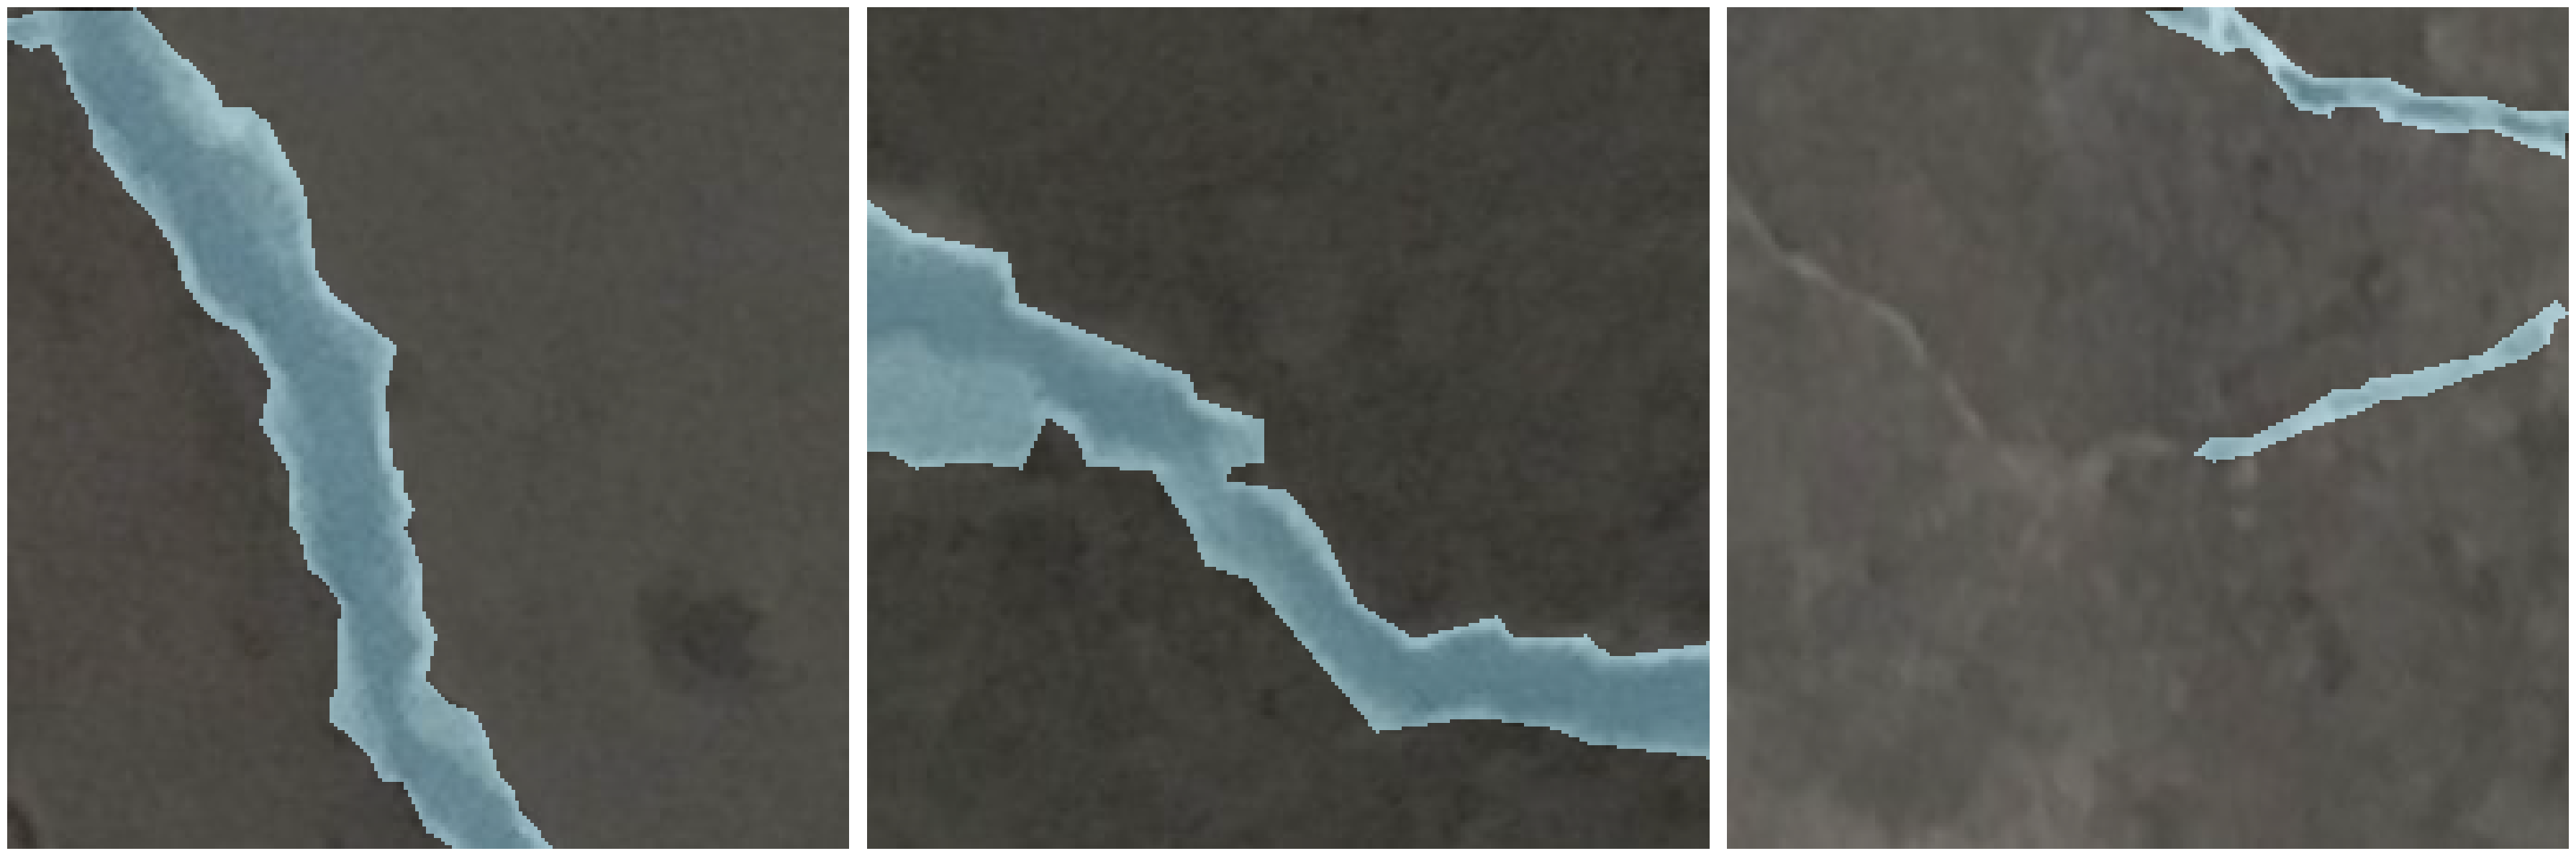

In [13]:
sample_records = random.choices(records, k=3)
show_records(sample_records, ncols=3)

## Transforms and datasets

In [14]:
presize, size = 512, 384
presize, size = ImgSize(presize, int(presize*.75)), ImgSize(size, int(size*.75))

aug_tfms = tfms.A.aug_tfms(presize=presize, size=size, pad=None,
                           crop_fn=partial(tfms.A.RandomCrop, p=0.5),
                           shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=2),
                          )
train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.resize(size), tfms.A.Normalize()])

In [15]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

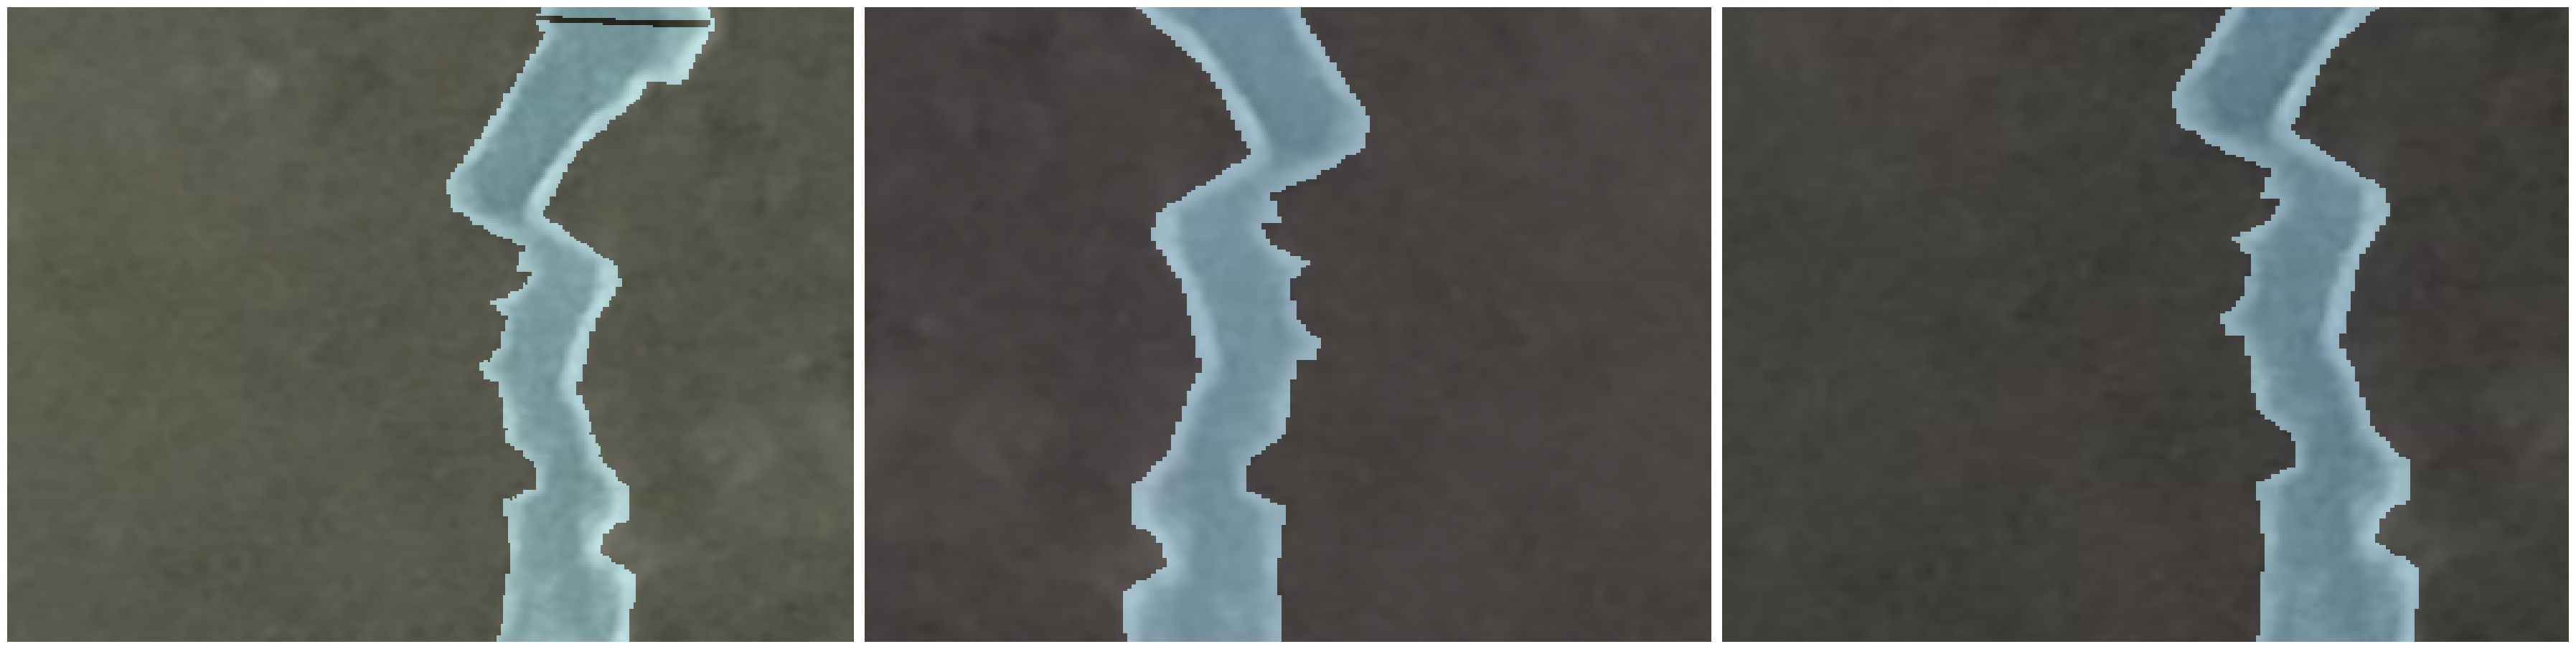

In [16]:
ds_samples = [train_ds[0] for _ in range(3)]
show_samples(ds_samples, ncols=3)

## UNET model and dataloaders

In [17]:
model_type = models.fastai.unet

In [18]:
train_dl = model_type.train_dl(train_ds, batch_size=2, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=2, num_workers=4, shuffle=False)

In [19]:
# model_type.show_batch(first(valid_dl), ncols=4)

In [20]:
backbone = model_type.backbones.resnet34()
model = model_type.model(backbone=backbone, num_classes=class_map.num_classes, img_size=size)

## Defining and training the `fastai` learner

In [21]:
def accuracy_camvid(pred, target):
    # ignores void pixels
    keep_idxs = target != class_map.get_by_name('Void')
    target = target[keep_idxs]
    pred = pred.argmax(dim=1)[keep_idxs]

    return (pred==target).float().mean() 

In [22]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=[accuracy_camvid])

In [23]:
learn.lr_find()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
learn.fine_tune(10, 1e-4)

In [ ]:
model_type.show_results(model, valid_ds, num_samples=2)

## Inference

In [ ]:
preds = model_type.predict(model, valid_ds)
show_preds(preds=preds[:3])

In [ ]:
infer_dl = model_type.infer_dl([valid_ds[0]], batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

In [ ]:
show_sample(preds[0].pred)